<a href="https://colab.research.google.com/github/nkapoor11/machine-learning/blob/main/Final_Adversarial_Many_gradient_steps_Patch_test_images%2C_zero_gradients%2C_perturbation%2C_with_defense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import PIL


# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)


In [ ]:
from matplotlib import cm

def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
    # assert 0 <= v <= 20
    if v < 0:
        return img
    #w, h = img.size
    w = 28-v
    h = 28-v
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)

    #print(type(img))
    #print(np.shape(img))
    #plt.imshow(img, cmap="gray") # before patch is added


  #  x0 = int(max(0, x0 - v / 2.))
  #  y0 = int(max(0, y0 - v / 2.))
    x1 = x0 + v #min(w, x0 + v)
    y1 = y0 + v #min(h, y0 + v)
    
    for i in range(len(img)):
      if (i >= x0 and i <= x1):
        for j in range(len(img[i])):
          if (j >= y0 and j <= y1):
            img[i][j] = 0.5 #128 #(128, 128, 128)    

    #plt.imshow(img, cmap="gray") # after patch is added
    return img, x0, x1, y0, y1

In [ ]:
#pretrained_model = "/content/lenet_mnist_model.pth"
use_cuda=True

In [ ]:
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  False


In [ ]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10) #(_, 2) means 2 classes (has patch, or no patch).

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
#dataset = datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
#            transforms.ToTensor(),
#            ]))

#print(type(dataset))

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True) # 10,000
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True) # 60,000 images

allmnist = [] # original 10,000 images w/o patch
allmnistpatch = [] # all 10,000 images w/ patches

counter = 0
x0_list = []
x1_list = []
y0_list = []
y1_list = []


for data, labels in test_loader:
  
  if (counter == 1):
    break
  counter+=1
  img = data.squeeze().numpy() # only 1 image b/c batch_size = 1.
  allmnist.append(img)
  #print(img.size)

  imgCopy = img.copy()
  img_patch, x0, x1, y0, y1 = CutoutAbs(imgCopy, 5)
  x0_list.append(x0)
  x1_list.append(x1)
  y0_list.append(y0)
  y1_list.append(y1)

  allmnistpatch.append(img_patch)


  #print('printing original img')
  #plt.imshow(img, cmap="gray") 

  #for i in range(len(img)):
    #print(img[i])
  
  if(counter % 10000 == 0):
    plt.imshow(img_patch, cmap="gray")
    #break
print("length before train added: {}, {}".format(len(allmnist), len(allmnistpatch)))
counter = 0
print('done')
print(type(allmnist))
#allmnist = allmnist.numpy()
print(np.shape(allmnist))



labels = []
labelspatch = []
for i in range(len(allmnist)):
  labels.append(0)
  labelspatch.append(1)
print(len(labels))
print(len(labelspatch))




length before train added: 1, 1
done
<class 'list'>
(1, 28, 28)
1
1


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
#device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
#model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# FOR TESTING/VALIDATION: Set the model in evaluation mode. In this case this is for the Dropout layers
#model.eval()

CUDA Available:  False


In [ ]:
loss_arr = []

In [ ]:
import torch.optim as optim
import torch.utils.data as data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.utils import resample
import random

class DatasetWithPatch(data.Dataset):    
    def __init__(self, x0_list, x1_list, y0_list, y1_list, allimages, allimagespatch, alllabels, alllabelspatch, phase, transform=None):
        """Data loader for Model."""
        super(DatasetWithPatch, self).__init__()
        
        #train, val, test
        self.phase = phase
        myimgs = []
        all_labels = []
        startind = 0
        endind = 0
        
        print("startind", startind)
        print("endind", endind)
        #for i in range(startind,endind):

        # To add images with patch: 
        for i in range(len(allimagespatch)): 
          # myimgs has 10,000 (perturbed) patch images in test mode.
          #myimgs.append(allimages[i])
          myimgs.append(allimagespatch[i]) # this line for adding images with patch for testing. 
          #all_labels.append(alllabels[i])
          all_labels.append(alllabelspatch[i]) # this line for adding images with patch for testing. 
        # if (self.phase == "train"):
        #   # myimgs has 20,000 (unperturbed) patch and no patch images in train mode. 
        #   for i in range(len(allimagespatch)):
        #     myimgs.append(allimages[i]) # allimages has no patches. Just regular MNIST images. 
        #     all_labels.append(alllabels[i]) # alllabels is all zeros
        #     x0_list.append(-1)
        #     x1_list.append(-1)
        #     y0_list.append(-1)
        #     y1_list.append(-1)
        print("length of myimgs", len(myimgs))
        print("length of all_labels", len(all_labels))
        #self.imgs = myimgs
        #self.all_labels = all_labels

        #shuffle data here
        #group images and albels together
        #shuffle
        #ungroup
        temp = list(zip(myimgs, all_labels, x0_list, x1_list, y0_list, y1_list))
        random.shuffle(temp)
        myimgs, all_labels, x0_list, x1_list, y0_list, y1_list = zip(*temp)
        self.imgs = myimgs
        self.all_labels = all_labels

        self.x0list = x0_list 
        self.x1list = x1_list
        self.y0list = y0_list
        self.y1list = y1_list

    
    #getitem is called 'batch_size' number of times in one iteration of the epoch
    def __getitem__(self, i):
        img_frame = self.imgs[i] #3 stacked frames (rgb) from same patient OR same image x3    

        x0 = self.x0list[i]
        x1 = self.x1list[i]
        y0 = self.y0list[i]
        y1 = self.y1list[i]

        #create label for image
        label = torch.LongTensor(1)
        #print('label type[i]: ', type(self.all_labels[i]))
        #print('label[i]: ', self.all_labels[i])
        #print('length of label[i]: ', len(self.all_labels[i]))
        label[0] = int(self.all_labels[i])

        input1 = torch.from_numpy(img_frame).float()            
        return {'input': input1, 'label': label, 'x0': x0, 'x1': x1, 'y0': y0, 'y1': y1 }

    def __len__(self):
        return len(self.imgs)

In [ ]:
# calls init in DatasetWithPatch
train_set = DatasetWithPatch(x0_list, x1_list, y0_list, y1_list, allimages=allmnist, allimagespatch=allmnistpatch, 
                 alllabels=labels, alllabelspatch=labelspatch, phase="train", transform=None)
train_set_loader = DataLoader(dataset=train_set, batch_size=16, shuffle=False)


startind 0
endind 0
length of myimgs 1
length of all_labels 1


In [ ]:
loss_arr = []

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad, x0_i, x1_i, y0_i, y1_i):
    #print('in fgsm. image shape:',np.shape(image))
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad#.sign()
    #print('sign_data_grad b:', np.shape(sign_data_grad)) # [1,28,28]
    sign_data_grad = torch.squeeze(sign_data_grad) 
    #print('sign_data_grad a:', np.shape(sign_data_grad))# [28,28]
    #print('fgsm sign_data_grad:', sign_data_grad[0:20])
    #print('in fgsm. epsilon*sign_data_grad shape:', np.shape(epsilon*sign_data_grad))
    # Create the perturbed image by adjusting each pixel of the input image
    #print('epsilon*sign_data_grad:', epsilon*sign_data_grad)
    '''for k in range(len(sign_data_grad)):
      for j in range(len(sign_data_grad[0])):
        if k < x0_i or k > x1_i or j < y0_i or j > y1_i: # outside the patch
          continue
          #data_grad_i[k][j] = 0
        else:
          #print('epsilon*sign_data_grad:', epsilon*(sign_data_grad[k][j]))'''

    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
#paste other code
def train(model, device, train_set_loader):
  #define criterion as crossentropy: 
  criterion = nn.CrossEntropyLoss()
  #define optimizer as SGD, which is an optimization algorithm.

  train_all_labels = []
  train_all_probs_ones = []

  #add final linear layer for 2 output classes
  model.fc2 = nn.Linear(50, 2)

  # Load trained weights
  model.load_state_dict(torch.load("/content/patch_net.pth", map_location='cpu')) # load patch_net weights

  model.to(device) # must do this AFTER re-defining fc2 layer

  for param in model.parameters():
    param.requires_grad = True
  
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  loss_arr = [] # for each epoch
  ploss_arr = []

  print("Printing model:", model)

  #model.train() # puts model layers in train mode. In contrast to model.eval() 
  num_epochs = 1
  
  model.eval() # although we are computing gradients, we are NOT updating the model by not doing the optimizer. So put the model in test mode. 

  for epoch in range(num_epochs): #EPOCHS. 50 OR 100 times or until validation loss starts increasing. 
    
    running_loss = 0.0
    prunning_loss = 0.0
    correct = 0
    counter = 0
    print("\nEPOCH #:", epoch)
    #print("len(train_set_loader)", len(train_set_loader)) # 125
    for i, data in enumerate(train_set_loader):
      #get ur inputs and labels here
      inputs = data['input'].to(device)
      labels = data['label'].to(device)
      #print('len(labels):', len(labels))
      counter += len(inputs)
      #if (i==0):
        #print("counter should be 16:",counter)
      #reset gradients
      optimizer.zero_grad() #no accumulated gradients from other batches
      #if i % 1000 == 0:
        #print("input dimensions before unsqueeze: ", inputs.size())
      inputs = torch.unsqueeze(inputs, 1)
      #if i % 1000 == 0:
        #print("input dimensions after unsqueeze: ", inputs.size())
      inputs.requires_grad = True

      # forward + backward + optimize (to find good parameters: weights + bias)
      outputs = model(inputs).to(device) #FEED DATA INTO MODEL
      if (i % 100 == 0):
        #print("outputs shape:", np.shape(outputs.detach().cpu().numpy()))
        #print("outputs:", outputs.detach().cpu().numpy())
        #print("labels shape before squeeze:", np.shape(labels.cpu().numpy()))
        labels = labels.squeeze(1) #might not need this
        #print("labels shape after squeeze:", np.shape(labels.cpu().numpy()))
      else:
        labels = labels.squeeze(1) #might not need this
      

      loss = criterion(outputs, labels) #calculate loss
      loss.backward() #backpropagate loss
      running_loss += loss.item()
      if i % 50 == 0:    # print every 200 mini-batches
        print("Running lossunperturbed:", running_loss)
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / (i+1)))
#            running_loss = 0.0
      #print('here1')
      x0_batch = data['x0'] # x0 values for 16 images
      x1_batch = data['x1']
      y0_batch = data['y0']
      y1_batch = data['y1']
      #print('here2')
      data_grad = inputs.grad.data # stores gradients for 16 images
      #print('len(data_grad):', len(data_grad)) # 16
      #print('data_grad shape:', np.shape(data_grad))
      #print('here3')

      perturbed_patch_imgs = torch.zeros(0, 28, 28)#np.zeros([0, 28, 28]) # reset every batch 
      #print('here4')
      for z in range(len(data_grad)): 
        if (labels[z] == 1): # has patch
          img_i = inputs[z] # type is torch tensor. fgsm attack wants a torch tensor.
          
          img_i = torch.squeeze(img_i)
          plt.imshow(img_i.detach().numpy(), cmap="gray") 
          x0_i = x0_batch[z]
          x1_i = x1_batch[z]
          y0_i = y0_batch[z]
          y1_i = y1_batch[z]
          data_grad_i = data_grad[z]
          #print('img_i shape:',np.shape(img_i), np.shape(img_i[0]))
          #print(len(img_i), len(img_i[0]))
          '''for a in range(len(img_i)):
            for b in range(len(img_i[0])):
              if a < x0_i or a > x1_i or b < y0_i or b > y1_i:
                continue
              else:
                print('unperturbed image pixels in patch:', img_i[a][b])'''

          # keep patch gradients, zero everything else
          #print('data_grad_i shape:',np.shape(data_grad_i))
          for k in range(len(data_grad_i)):
            for j in range(len(data_grad_i[0])):
              if k < x0_i or k > x1_i or j < y0_i or j > y1_i: # outside the patch
                #print('in here')
                data_grad_i[k][j] = 0
                #print(data_grad_i[k][j])
              #else:
                #print('pixel gradient [', k,'][', j, '] in patch:', data_grad_i[k][j])

          #print('done zeroing patch gradients')
          neg_eps_for_attack = -0.01
          pos_epsilon_for_defense = .1
          perturbed_patch_img_defense = fgsm_attack(img_i, pos_epsilon_for_defense, data_grad_i, x0_i, x1_i, y0_i, y1_i)
          num_gradient_steps = 1000
          perturbed_patch_img = img_i
          print(np.shape(perturbed_patch_img))
          print(type(perturbed_patch_img))
          probabilities = []
          for i in range(num_gradient_steps):
            #print('here1', np.shape(perturbed_patch_img))
            perturbed_patch_img = fgsm_attack(perturbed_patch_img, neg_eps_for_attack, data_grad_i, x0_i, x1_i, y0_i, y1_i)
            #print('here2', np.shape(perturbed_patch_img))
            perturbed_patch_img = torch.squeeze(perturbed_patch_img) # squeeze to get to 28 by 28
            #print('here3', np.shape(perturbed_patch_img))
            perturbed_patch_img = torch.unsqueeze(perturbed_patch_img, 0)
            #print('here4', np.shape(perturbed_patch_img))
            perturbed_patch_imgs = torch.cat((perturbed_patch_imgs, perturbed_patch_img))
            #print('here5', np.shape(perturbed_patch_img))
            # squeeze perturbed_patch_img again so
            perturbed_patch_img = torch.squeeze(perturbed_patch_img)
            perturbed_patch_imgs = torch.unsqueeze(perturbed_patch_imgs, 1)
            #print('here6', np.shape(perturbed_patch_img))
            poutputs = model(perturbed_patch_imgs)
            perturbed_patch_imgs = torch.zeros(0, 28, 28)
            sf = nn.Softmax(dim=1) #makes items in a row add to 1; dim = 0 makes items in a column add to 1
            poutputs = sf(poutputs)
            #print('image', i, 'softmax', poutputs.detach().cpu().numpy()) #poutputs[0], poutputs.detach().cpu().numpy()[:, 1])
            probabilities.append(poutputs.detach().cpu().numpy()[:, 1][0])
            #print('here7', np.shape(perturbed_patch_img))
          print('outside')
          perturbed_patch_img = torch.squeeze(perturbed_patch_img) # squeeze to get to 28 by 28
          #print('here1')
          #if (i % 50 == 0):
          #print(x0_i, x1_i, y0_i, y1_i)
          '''for a in range(len(perturbed_patch_img)):
            #print('here1')
            for b in range(len(perturbed_patch_img[0])):
              #print('here2')
              if a < x0_i or a > x1_i or b < y0_i or b > y1_i: # outside patch
                #print('here3')
                #print('in here')
                print('image pixels outside patch:[',a,'][',b,']',perturbed_patch_img[a][b])
                #continue
             # else:
                #print('perturbed_patch_img shape:',np.shape(perturbed_patch_img), np.shape(perturbed_patch_img[0]))
                #print('image pixels in patch:[',a,'][',b,']',perturbed_patch_img[a][b])
          '''
          perturbed_patch_img = torch.unsqueeze(perturbed_patch_img, 0) # back to [1,28,28]
          perturbed_patch_imgs = torch.cat((perturbed_patch_imgs, perturbed_patch_img))#.append(perturbed_patch_img)
          
          #if(i%100==0):
           # print(np.shape(perturbed_patch_imgs))
      
      '''for z in range(len(data_grad)):
        #if (labels[z] == 1): # has patch
          img_i = inputs[z] # type is torch tensor. fgsm attack wants a torch tensor.
          perturbed_patch_imgs = torch.cat((perturbed_patch_imgs, img_i))#.append(perturbed_patch_img)
      '''
      #print('here5')
      perturbed_patch_imgs = torch.unsqueeze(perturbed_patch_imgs, 1) # to [batch_size,1,28,28]
      #print('perturbed_patch_imgs:', np.shape(perturbed_patch_imgs), len(perturbed_patch_imgs))
      #perturbed_patch_imgs = torch.unsqueeze(perturbed_patch_imgs, 1)
      #print('here6')
      poutputs = model(perturbed_patch_imgs)#inputs) # just inputs instead of perturbed_patch_imgs will be just unperturbed, patch and no patch images. #perturbed_patch_imgs) 
      #print('poutputs:', np.shape(poutputs), len(poutputs))
      #print('here7')
      #print('len(perturbed_patch_imgs):', len(perturbed_patch_imgs))
      #print(len(perturbed_patch_imgs))

      plabels = torch.ones((len(perturbed_patch_imgs))).long() #labels[:len(perturbed_patch_imgs)]
      #print('plabels:', np.shape(plabels), len(plabels))
      #print(len(perturbed_patch_imgs))
      #print('here8')
      #print(len(poutputs), len(plabels))
      ploss = criterion(poutputs, plabels) #calculate loss
      #print('here9')
      prunning_loss += ploss.item()
      #print('here10')
      if i % 50 == 0:    # print every 200 mini-batches
        print("Running loss Perturbed:", prunning_loss)
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, prunning_loss / (i+1)))
        print('poutputs[0]', poutputs[0])    

      #apply sigmoid or softmax
      sf = nn.Softmax(dim=1) #makes items in a row add to 1; dim = 0 makes items in a column add to 1
      poutputs = sf(poutputs)
      print('softmax', poutputs[0])

      #if i % 500 == 0:
        #print("len poutputs", np.shape(poutputs), "poutputs[0]:", poutputs[0]) # length of outputs is batch_size (16) by # of classes (2).
      
      # Get predictions from the maximum value
      _, predicted = torch.max(poutputs, 1)

      # #add labels + predictions to full set for auroc later
      if torch.cuda.is_available():
          outs_ones = poutputs.detach().cpu().numpy()[:, 1]
          plabelsnp = plabels.cpu().numpy()
          correct += (predicted.cpu() == plabels.cpu()).sum()
      else:
          outs_ones = poutputs.detach().numpy()[:, 1]
          plabelsnp = plabels.numpy()
          correct += (predicted == plabels).sum()

      # counter += len(predicted.cpu())

      accuracy = 100 * correct // counter
      if (i % 100 == 0):
        print("accuracy for iteration {} = {} %. {} correct out of count {}".format(i, accuracy, correct, counter))
      
    PATH = '/content/patch_net_adv.pth'
    torch.save(model.state_dict(), PATH)
    ploss_arr.append( prunning_loss / len(train_set_loader))
  # plot loss
  plt.figure(figsize=(5,5))
  # plt.plot(ploss_arr)
  plt.plot(probabilities)
  plt.plot()
  # plt.yticks(np.arange(0, 1.1, step=0.1))
  # plt.xticks(np.arange(0, .5, step=0.1))
  plt.title("Probability of patch for {} gradient steps and pos epsilon = {} and neg eps = {}".format(num_gradient_steps, pos_epsilon_for_defense, neg_eps_for_attack))
  plt.xlabel("Gradient step")
  plt.ylabel("Softmax probability of 1 (has patch)")
  # plt.show()
  return perturbed_patch_imgs


Printing model: Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)

EPOCH #: 0
Running lossunperturbed: 0.5461991429328918
[1,     1] loss: 0.546
torch.Size([28, 28])
<class 'torch.Tensor'>


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


outside
softmax tensor([0.4209, 0.5791], grad_fn=<SelectBackward>)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


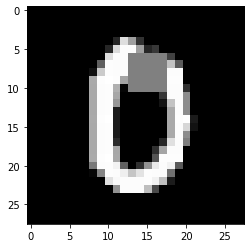

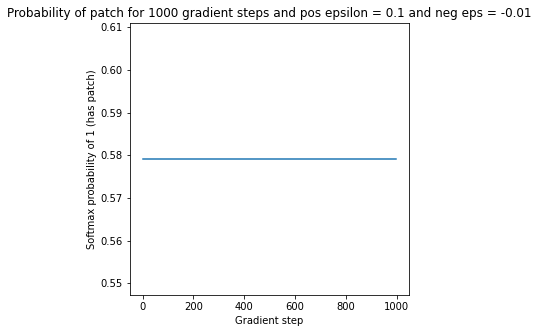

In [ ]:
print()
perturbed_patch_imgs = train(model, device, train_set_loader)

In [ ]:
perturbed_patch_imgs = perturbed_patch_imgs.detach().numpy()